In [2]:
import scipy, GPy
from gpmultipy import dataset

In [3]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [4]:
%matplotlib inline

In [5]:
ds = dataset.DataSet('data/')

# x,y,effect,labels = ds.build(Strain='ura3',scale='range',effects=['Well','Bio','mM_PQ'])
x,y,effect,labels = ds.build(Strain='ura3',scale='range',Bio=['B','C','D'],effects=['Well','Bio','mM_PQ'])

# remove early time points
x = x[6:,:]
y = y[6:,:]

# observations that are on an edge are removed
edge = range(101,111) + range(111,191,10) + range(120,191,10) + range(191,201) + range(201,211) + range(211,291,10) + range(220,291,10) + range(291,301)
edge = np.array(edge)

dist = np.array([min(abs(l-edge)) for l in labels[0]])
position = (dist==0).astype(int)

select = dist > 0
y = y[:,select]
effect = effect.iloc[select,:]

# standardize
y = np.log2(y)

# scale to 0 within bio reps
# for i,p in enumerate(effect.Bio.unique()):
#     select = effect.Bio==p
#     y[:,select] -= y[0,select].mean()

y = (y-y.mean())/y.std()

y.shape

(139, 51)

In [9]:
xgp = np.zeros((x.shape[0]*y.shape[1], 2))
xgp[:,0] = np.tile(x[:,0], y.shape[1])
xgp[:,1] = np.repeat(effect.mM_PQ.values,x.shape[0])

#replace effect index with actual value
xgp[:,1] = [labels[2][int(i)] for i in xgp[:,1]]

ygp = y.ravel(1)[:,None]

# xgp = xgp[:x.shape[0]*15,:]
# ygp = ygp[:x.shape[0]*15,:]

xgp = xgp[::10]
ygp = ygp[::10]

xgp.shape

(709, 2)

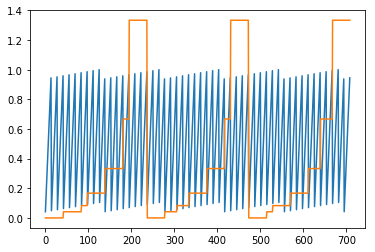

In [10]:
plt.plot(xgp)

In [11]:
m = GPy.models.GPRegression(xgp,ygp,GPy.kern.RBF(2,ARD=True))
m.randomize()
m

GP_regression.,value,constraints,priors
rbf.variance,2.00032028592,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,1.63198146782,+ve,


In [12]:
m.optimize()
m

GP_regression.,value,constraints,priors
rbf.variance,0.799214620504,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.0180930771139,+ve,


In [13]:
m.kern.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.27734418,+ve,
[1],0.41180825,+ve,


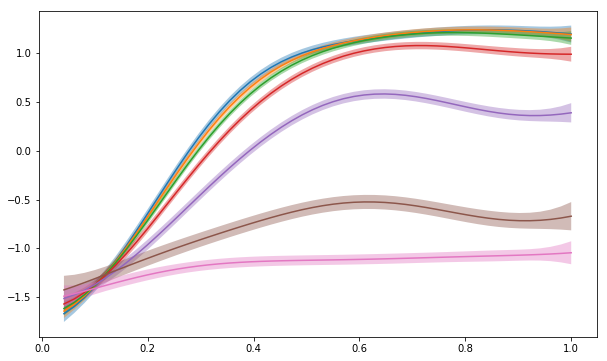

In [26]:
xpred = np.zeros((50*len(labels[2]), 2))
xpred[:,0] = np.tile(np.linspace(x.min(),x.max()),len(labels[2]))
xpred[:,1] = np.repeat(labels[2],50)

mu,cov = m.predict_noiseless(xpred,)

mu = mu.reshape(len(labels[2]), 50).T
cov = cov.reshape(len(labels[2]), 50).T

std = np.sqrt(cov)

plt.figure(figsize=(10,6))
lines = plt.plot(xpred[:50,0], mu)

for i in range(mu.shape[1]):
    plt.fill_between(xpred[:50,0], mu[:,i]-1.96*std[:,i], mu[:,i]+1.96*std[:,i],alpha=.4)